In [9]:
import math, random, operator
import numpy as np
from functools import reduce
import operator
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.corpus import wordnet as wn
plt.style.use('ggplot')

from functools import reduce

In [10]:


def pplot(pdict,pembs,name='mammal'):
	fig = plt.figure(figsize=(10,10)); ax = plt.gca(); ax.cla()
	ax.set_xlim((-1.1,1.1)); ax.set_ylim((-1.1,1.1))
	ax.add_artist(plt.Circle((0,0),1.,color='black',fill=False))
	for w,i in pdict.items():
		c0,c1 = pembs[i]
		ax.plot(c0,c1,'o',color='y')
		ax.text(c0+.01,c1+.01,w,color='b')
	fig.savefig('data/'+name+'.png',dpi=fig.dpi); # plt.show()

class PoincareBase(object):
	def __init__(self,num_iter=10,num_negs=10,lr1=0.2,lr2=0.01,dp='data/music_genre_network.tsv'): # dim=2
		self.dim = 2
		self.num_iter = num_iter
		self.num_negs = num_negs
		self.lr1, self.lr2 = lr1, lr2

		self.pdata = list(map(lambda l:l.split('\t'),filter(None,open(dp).read().split('\n'))))
		self.pdict = {w:i for i,w in enumerate(set(reduce(operator.add,self.pdata)))}

        
        
	def dists(self,u,v): pass
	def train(self): pass


In [11]:
class PoincareNumpy(PoincareBase):
	eps = 1e-6
	def __init__(self,num_iter=10,num_negs=10,lr1=0.2,lr2=0.01,dp='data/music_genre_network.tsv'): # dim=2
		super(PoincareNumpy,self).__init__(num_iter,num_negs,lr1,lr2,dp)
		self.pembs = [np.random.uniform(low=-0.001,high=0.001,size=(self.dim,)) for i in range(len(self.pdict))]
	def add_clip(self,c,u,v,thresh=1.-eps):
		uu, uv, vv = (u**2).sum(), (u*v).sum(), (v**2).sum(); C = uu+2*c*uv+c*c*vv
		scale = thresh/C**0.5 if C>thresh**2 else 1.
		return (u+c*v)*scale
	def acosh(self,x):
		return math.log(x+(x**2-1)**0.5)
	def dists(self,u,v):
		uu, uv, vv = (u**2).sum(), (u*v).sum(), (v**2).sum()
		alpha, beta = max(self.eps,1-uu), max(self.eps,1-vv)
		gamma = max(1.,1+2*(uu-2*uv+vv)/alpha/beta)
		return self.acosh(gamma), (u,v,uu,uv,vv,alpha,beta,gamma)
	def backward(self,gdo,env):
		c = gdo; u,v,uu,uv,vv,alpha,beta,gamma = env
		if gamma == 1: return None, None
		c *= 4./(gamma**2-1)**0.5/alpha/beta
		cu, cv = c*alpha**2/4., c*beta**2/4.
		gdu = cu*((vv-2*uv+1)/alpha*u-v)
		gdv = cv*((uu-2*uv+1)/beta*v-u)
		return gdu, gdv
    
	def train(self): # BOTH SAMPLING
		pdata, pdict, pembs = self.pdata, self.pdict, self.pembs
		def neg_sampling(i1,i2,lp=range(len(pdict))):
			d,env = self.dists(pembs[i1],pembs[i2])
			yield i1,i2,math.exp(-d),env
			for _ in range(self.num_negs):
				s1,s2 = random.choice(lp),random.choice(lp)
				d,env = self.dists(pembs[s1],pembs[s2])
				yield s1,s2,math.exp(-d),env
		for epoch in range(self.num_iter):
			random.shuffle(pdata)
			r = 1.*epoch/self.num_iter; lr = (1-r)*self.lr1+r*self.lr2
			for w1,w2 in pdata:
				i1,i2 = pdict[w1],pdict[w2]
				exp_neg_dists = list(neg_sampling(i1,i2))
				Z = sum(map(operator.itemgetter(2),exp_neg_dists))
				for i,(i1,i2,d,env) in enumerate(exp_neg_dists):
					gl,gr = self.backward(1.*(i==0)-d/Z,env)
					if gl is not None: pembs[i1] = self.add_clip(-lr,pembs[i1],gl)
					if gr is not None: pembs[i2] = self.add_clip(-lr,pembs[i2],gr)
        
		pplot(self.pdict,self.pembs,'mammal_numpy')

In [14]:
random.seed(123)

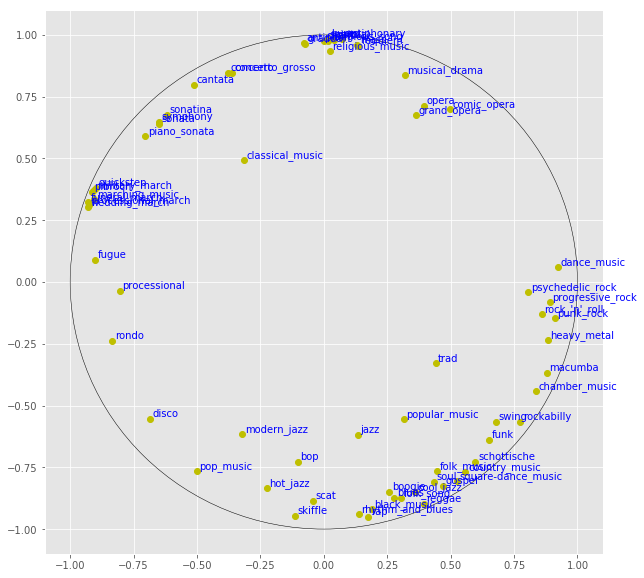

In [16]:
if __name__ == '__main__':
	PoincareNumpy(num_iter=100).train()